### Session State encoder using LSTM Autoencoder
We used LSTM netural network to create an autoencoder that will reduce the dimension of session which contains last 5 played songs features and action between those songs (5x9 matrix) to a smaller vector of 1x9.

In [1]:
import glob
import pandas as pd
import numpy as np
from tqdm import tqdm
from tensorflow.keras.layers import LSTM, Input, Dense, RepeatVector, TimeDistributed
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
latent_track_features_df = pd.read_csv("D:\Recommendation RL\Code\Data\latent_track_features.csv");
latent_track_features_df.head()

,track_id,0,1,2,3,4,5,6,7
0,t_3c2c29b5-c738-42c0-83e1-ee0e88ac834d,0.143063,0.024294,0.004624,-0.091005,0.067549,-0.291867,-0.285134,-0.150432
1,t_f48322ca-044e-4069-a797-4fedbbbbb522,-0.053658,-0.043300,0.071140,-0.061014,-0.044522,-0.037636,0.181544,0.003603
2,t_5487f622-5641-43da-b263-d8954845d163,0.030984,0.090996,-0.081795,-0.066444,0.240973,-0.241382,-0.244575,-0.090051
3,t_5f395f25-5236-4cbd-a41d-74b65e253df7,0.219336,0.094216,0.024554,-0.129817,0.134058,-0.223478,-0.103355,0.034922
4,t_081b193b-03bd-4c30-9255-b127ed5d2ad5,-0.068865,-0.148980,0.055289,-0.048050,-0.025559,-0.199426,-0.077340,-0.000362


In [3]:
latent_track_features_dict = latent_track_features_df.set_index('track_id').T.to_dict('list')

In [4]:
session_df = pd.read_csv("D:\Recommendation RL\Code\Data\session_track_reward_data.csv");
session_df.head()

,session_id,0,1,2,3,4,5,6,7,8,...,30,31,32,33,34,35,36,37,38,39
0,0_00602661-ec08-47d0-b23b-dcd249f45ecc,t_30cb664a-f513-4c4b-918f-5b383a261e12,0,t_e11adb6d-a49f-4614-bf2c-533705bcc29e,0,t_eeac9c96-f4f7-4618-a4b8-092250d6402e,1,t_5c5df2c3-8ce3-42ed-817f-440791f76368,0,t_b3fdb711-268c-472e-a856-3ba616ed0475,...,t_95f71f29-79bb-413b-91d5-78582cb0774c,0,t_b1bedaf2-a919-4f67-b340-15e383ed14e6,0,t_f6775101-da76-43d3-b54e-4a1704c5bfef,0,t_ac1f897f-25c7-4e0e-91b5-1030649dda4b,0,t_f6775101-da76-43d3-b54e-4a1704c5bfef,1
1,0_00646e66-c627-4e8c-b4a5-f68a30b623a0,t_b905c13c-670f-4ae1-a139-84b981045794,0,t_ffc37789-d3ce-4aa6-8e89-067ab0f18b21,0,t_b193cd79-b6cb-4514-8c5b-ead28ac8dd30,0,t_575964e1-d488-4929-9efe-e63ee8586d12,0,t_0ef6d2c8-faf9-4ebe-ac75-2bade8696a3d,...,t_9aef055a-151c-466d-a082-d2826d80ad5c,0,t_71bee55a-863c-41c8-864f-171b40c663d6,0,t_ee116f41-06dc-4f2a-87dc-494235de540e,0,t_244d8a7e-a290-424d-9b2e-05b06426914d,0,t_867d4494-ed16-4d5e-8415-3e2dc60827fc,0
2,0_006d0464-5910-4c4e-b8bf-98db3cd80a9a,t_a2c86617-1149-4a9c-bb0d-d304cd3ef077,0,t_58b65d28-3a54-467e-bf44-511aa89f44d4,0,t_d777aa56-bd42-4df5-ab7b-403526ed1862,1,t_4a6b1494-508d-48eb-a002-c1fad94b1bd8,1,t_77b02acb-1b1f-4b36-b8fc-2c3e01892b9a,...,t_24a69429-5fd7-41aa-a72d-ece8bd618b45,0,t_416f532e-1cb9-4271-a21c-bb5c78e492e9,1,t_7874301a-f2ba-4cc3-a38b-6efddaa89a2d,0,t_00c3f668-2283-447c-94c0-965c5c409f84,0,t_00c3f668-2283-447c-94c0-965c5c409f84,0
3,0_0096cd3a-dc9f-4a6e-aa50-93ed24e17be5,t_ea20035c-6a01-4e09-8c18-2d1e5fff9a61,1,t_02111b05-f8fd-477c-abb4-4bf2e2ed29dc,0,t_ea20035c-6a01-4e09-8c18-2d1e5fff9a61,0,t_279e04f8-5a85-4a83-9831-16d673673456,0,t_ea20035c-6a01-4e09-8c18-2d1e5fff9a61,...,t_0c09bf72-5cac-44d7-9050-dc4ae4ca3a04,0,t_900f7a9e-e082-4378-8705-ecce236cddf6,0,t_0c09bf72-5cac-44d7-9050-dc4ae4ca3a04,1,t_900f7a9e-e082-4378-8705-ecce236cddf6,0,t_0f554e14-572e-4538-a3e9-65c5fee7e580,0
4,0_0101fd8a-ff18-4435-a6f2-c2d2ce608aef,t_938cfd98-d6cf-48cc-a14a-f1426addbf34,0,t_4755ddd1-f2a1-4dfa-bbd4-59dc15de6bbe,0,t_4755ddd1-f2a1-4dfa-bbd4-59dc15de6bbe,1,t_4755ddd1-f2a1-4dfa-bbd4-59dc15de6bbe,1,t_4755ddd1-f2a1-4dfa-bbd4-59dc15de6bbe,...,t_5ee34da6-b6d3-4487-a03e-55b46ec25633,0,t_abcaac58-2a68-4e29-9da1-d50bed637bce,0,t_68897b2f-13fa-43ce-a1d8-1ffb6437a07e,0,t_8f9f2397-334b-48ee-9120-96d9ddf32f92,1,t_4403dd71-7265-4981-a1b9-fca58fa2679b,1


In [5]:
session_dict = session_df.set_index('session_id').T.to_dict('list')

Below function creates a matrix representation of a state in a session. A state holds the information of last 5 songs played along with the action between songs. So, this function takes input as last 5 songs and actions, and return a 5x9 matrix that represents that state.

In [6]:
def construct_state(track_and_reward_list):
    state_matrix = []
    for i in range(5):
        latent_track = latent_track_features_dict[track_and_reward_list[2*i]].copy()
        latent_track.append(track_and_reward_list[2*i + 1])
        state_matrix.append(latent_track)
    np_state_matrix = np.array(state_matrix)
    return np_state_matrix

In [7]:
state_list = []
for session_id in session_dict:
    track_and_reward_list = session_dict[session_id]
    for i in range(15):
        state = construct_state(track_and_reward_list[2*i:2*i + 10])
        state_list.append(state)

In [8]:
len(state_list)

149490

In [9]:
len(session_dict)

9966

### LSTM Autoencoder
We used LSTM autoencoder because the data is sequential.

from keras.models import Sequential from keras.layers import LSTM from keras.layers import Dense from keras.layers import RepeatVector from keras.layers import TimeDistributed

In [10]:
np_state_list = np.array(state_list)
print(np_state_list.shape)

(149490, 5, 9)


In [11]:
timesteps = np_state_list.shape[1]
n_features = np_state_list.shape[2]

In [12]:
# LSTM Auto-Encoder
model = tf.keras.Sequential()
model.add(LSTM(32, activation='tanh', input_shape=(timesteps, n_features), return_sequences=True))
model.add(LSTM(16, activation='tanh', return_sequences=False))
model.add(RepeatVector(timesteps))
model.add(LSTM(16, activation='tanh', return_sequences=True))
model.add(LSTM(32, activation='tanh', return_sequences=True))
model.add(TimeDistributed(Dense(n_features)))
model.compile(optimizer='adam', loss='mse', metrics='accuracy')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 32)             5376      
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                3136      
_________________________________________________________________
repeat_vector (RepeatVector) (None, 5, 16)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 5, 16)             2112      
_________________________________________________________________
lstm_3 (LSTM)                (None, 5, 32)             6272      
_________________________________________________________________
time_distributed (TimeDistri (None, 5, 9)              297       
Total params: 17,193
Trainable params: 17,193
Non-trainable params: 0
____________________________________________________

In [13]:
history = model.fit(np_state_list, np_state_list, epochs = 26, batch_size = 256,
                    use_multiprocessing = True, validation_split=0.25)
history

Epoch 1/26
438/438 [==============================] - 24s 34ms/step - loss: 0.0221 - accuracy: 0.4982 - val_loss: 0.0143 - val_accuracy: 0.5982
Epoch 2/26
438/438 [==============================] - 13s 29ms/step - loss: 0.0115 - accuracy: 0.6396 - val_loss: 0.0096 - val_accuracy: 0.6629
Epoch 3/26
438/438 [==============================] - 13s 29ms/step - loss: 0.0080 - accuracy: 0.6996 - val_loss: 0.0070 - val_accuracy: 0.7187
Epoch 4/26
438/438 [==============================] - 12s 29ms/step - loss: 0.0064 - accuracy: 0.7335 - val_loss: 0.0063 - val_accuracy: 0.7389
Epoch 5/26
438/438 [==============================] - 12s 28ms/step - loss: 0.0060 - accuracy: 0.7429 - val_loss: 0.0060 - val_accuracy: 0.7436
Epoch 6/26
438/438 [==============================] - 12s 28ms/step - loss: 0.0059 - accuracy: 0.7474 - val_loss: 0.0058 - val_accuracy: 0.7471
Epoch 7/26
438/438 [==============================] - 12s 28ms/step - loss: 0.0057 - accuracy: 0.7508 - val_loss: 0.0057 - val_accuracy:

LSTM AUTOENCODER MODEL


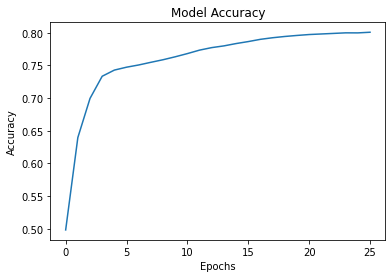

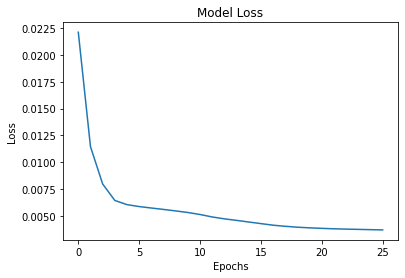

In [14]:
print("LSTM AUTOENCODER MODEL")
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.show()

LSTM AUTOENCODER MODEL


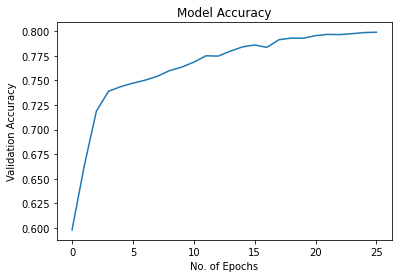

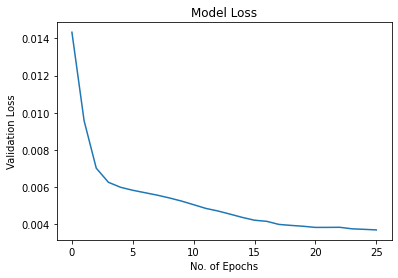

In [15]:
print("LSTM AUTOENCODER MODEL")
# summarize history for accuracy
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Validation Accuracy')
plt.xlabel('No. of Epochs')
plt.show()

# summarize history for loss
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Validation Loss')
plt.xlabel('No. of Epochs')
plt.show()

In [16]:
encoder = Model(inputs=model.inputs, outputs=model.layers[1].output)
encoder.save('Data/pickle/session_state_encoder.h5')